In [9]:
# Normal imports for everybody
from keras.models import Model
from keras import Sequential
from keras.layers import LSTM, Dense, Bidirectional, RepeatVector, TimeDistributed, Input, Dropout
from keras.optimizers import Adam
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import time

In [10]:
t=time.time()
X=np.loadtxt('X.csv',delimiter=',')
Y=np.loadtxt('Y.csv',delimiter=',')
print(time.time()-t)
print(np.shape(X),np.shape(Y))

97.84654426574707
(24571, 5000) (24571, 500)


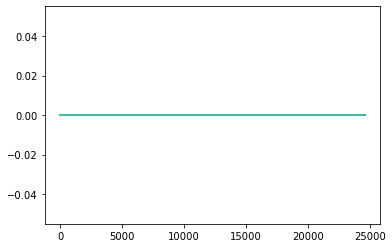

[-0.82188075  3.35414138  0.77480965 -0.57932854] [0.17953081 0.08178025 0.12285084 0.04704531]


In [11]:
X=np.reshape(X,(-1,1000,5))

plt.plot(X[:,:,4])
plt.show()
X=X[:,:,:4]

eps=1e-15

X=X*(X>0)
X=np.log10(X+eps)

#Normalising X
x_mean=np.mean(np.mean(X,axis=0),axis=0)
x_std=np.std(np.std(X,axis=0),axis=0)
print(x_mean,x_std)
for i in range(4):
    X[:,:,i]=(X[:,:,i]-x_mean[i])/x_std[i]

#X=np.reshape(X,(-1,1000*4))

Y=np.log10(Y*1e20)

#Min_Max Scaling of Y
y_min=np.min(Y)
Y=Y-y_min
y_max=np.max(Y)
Y=Y/y_max

Y=np.reshape(Y,(-1,500,1))

In [12]:
Y=np.reshape(Y,(-1,500,1))

In [15]:
latent_dim=32
batch_size=256

model = Sequential()
model.add(Bidirectional(LSTM(latent_dim), input_shape=(1000,4)))
model.add(RepeatVector(500))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(latent_dim, return_sequences=True)))
model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 64)                9472      
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 500, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 500, 64)           24832     
_________________________________________________________________
dropout_12 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
time_distributed_11 (TimeDis (None, 500, 100)          6500      
_________________________________________________________________
time_distributed_12 (TimeDis (None, 500, 1)            101       
Total para

In [16]:
history = model.fit(X, Y, batch_size=batch_size, epochs=3, validation_split=0.15, shuffle=False) #callbacks=[keras.callbacks.TerminateOnNaN()]
model.summary()

Train on 20885 samples, validate on 3686 samples
Epoch 1/3
20885/20885 [==============================] - 336s 16ms/step - loss: 0.0129 - val_loss: 0.0058
Epoch 2/3
20885/20885 [==============================] - 378s 18ms/step - loss: 0.0062 - val_loss: 0.0056
Epoch 3/3
20885/20885 [==============================] - 373s 18ms/step - loss: 0.0060 - val_loss: 0.0055
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 64)                9472      
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 500, 64)           0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 500, 64)           24832     
_______________________________________

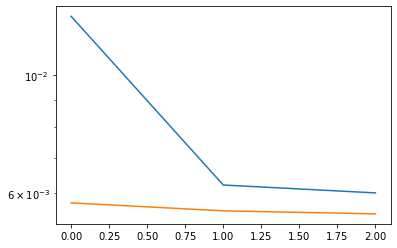

In [17]:
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])

In [18]:
import scipy.ndimage.filters as sp
from scipy.special import softmax
import importlib
import bolsig
importlib.reload(bolsig)
from bolsig import bolsig

In [19]:
n=10

In [20]:
X_new=np.copy(np.reshape(X,(-1,1000,4))[:n,:,:])
y_hat=model.predict(X_new)
#y_hat=sp.gaussian_filter1d(y_hat,20)

|(1000, 4)


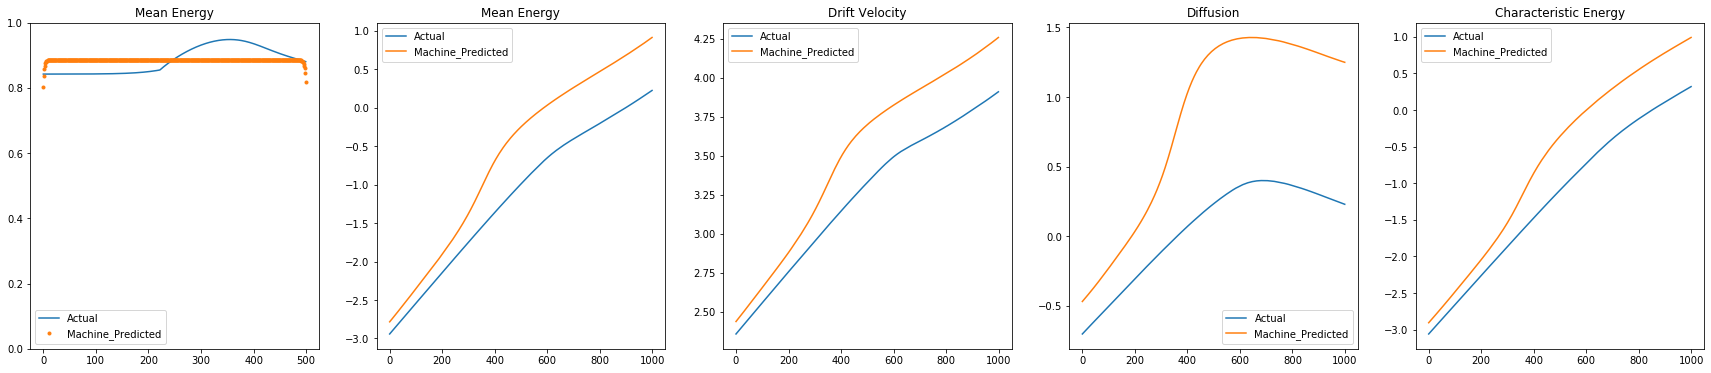

|(1000, 4)


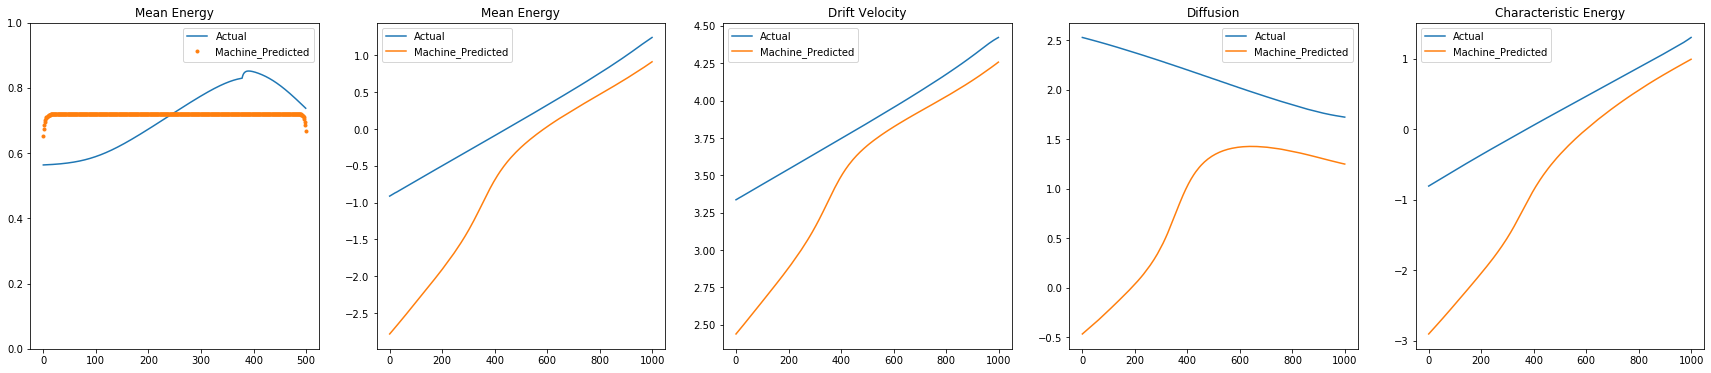

|(1000, 4)


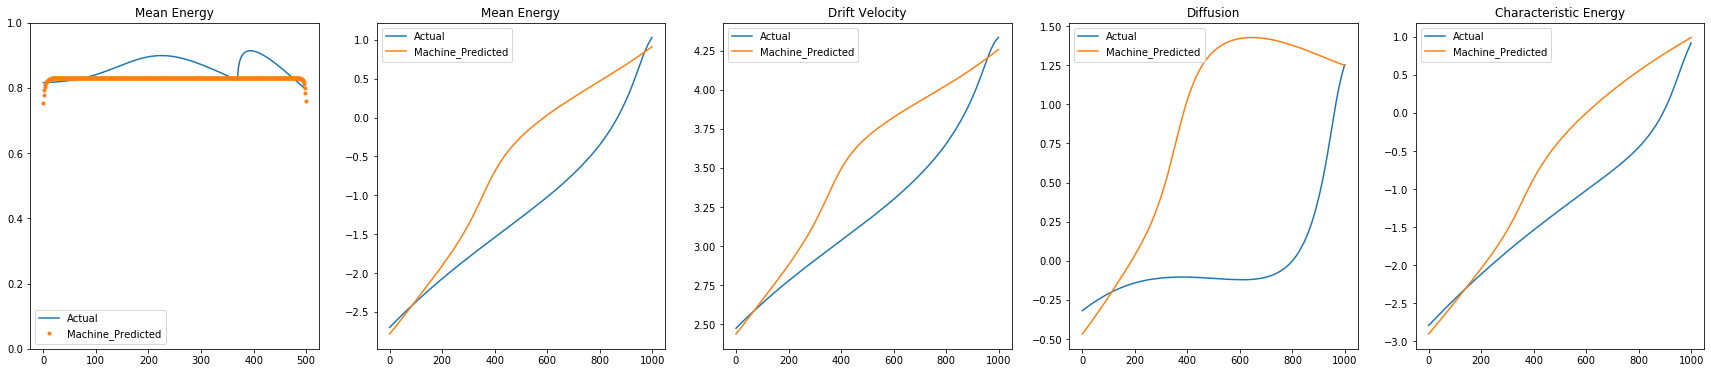

|(1000, 4)


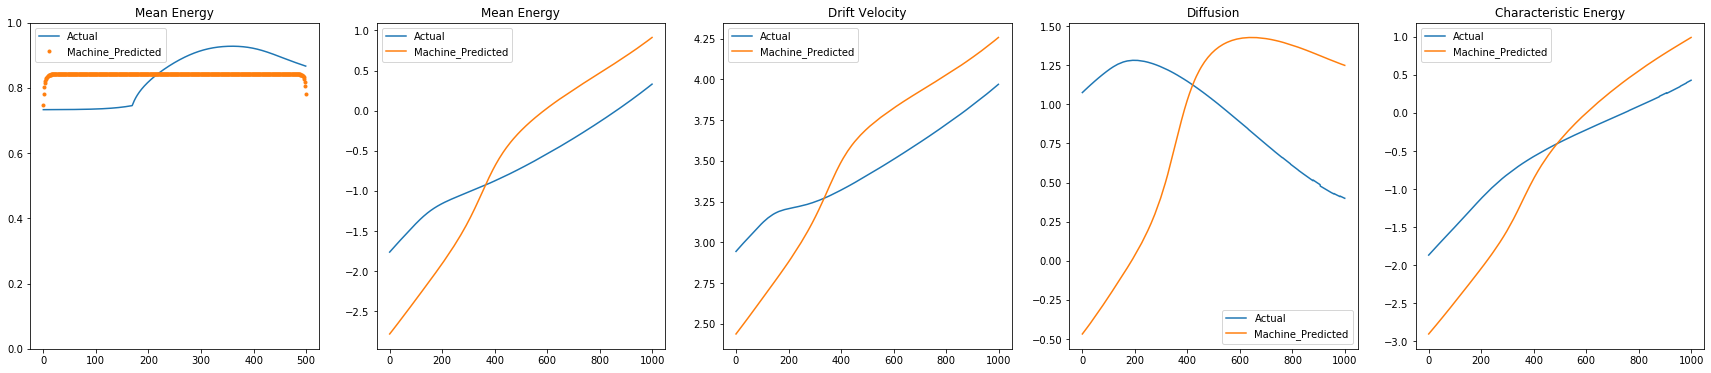

|(1000, 4)


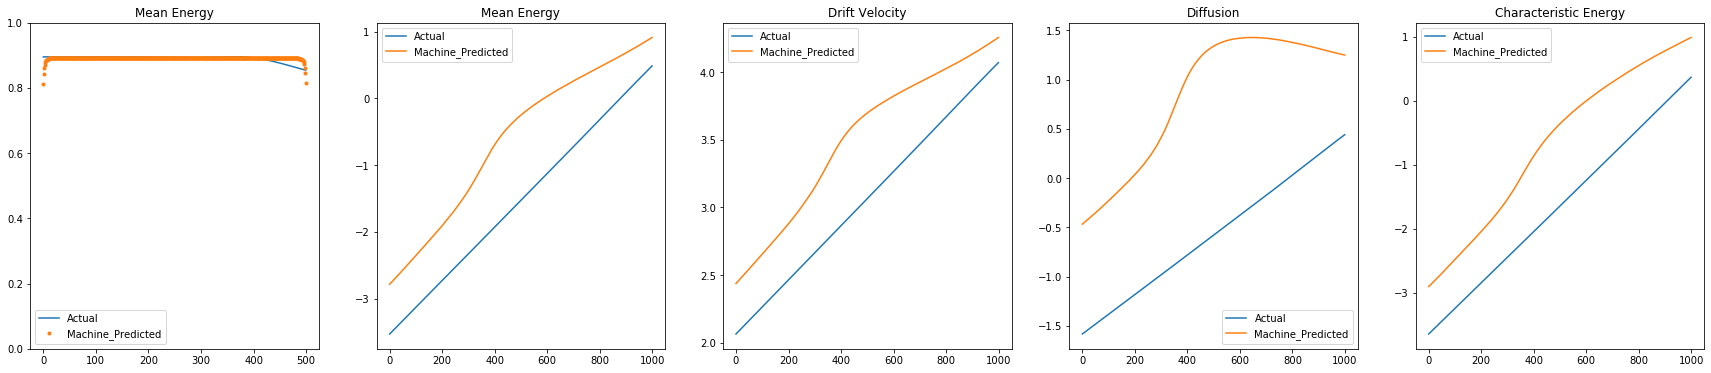

|(1000, 4)


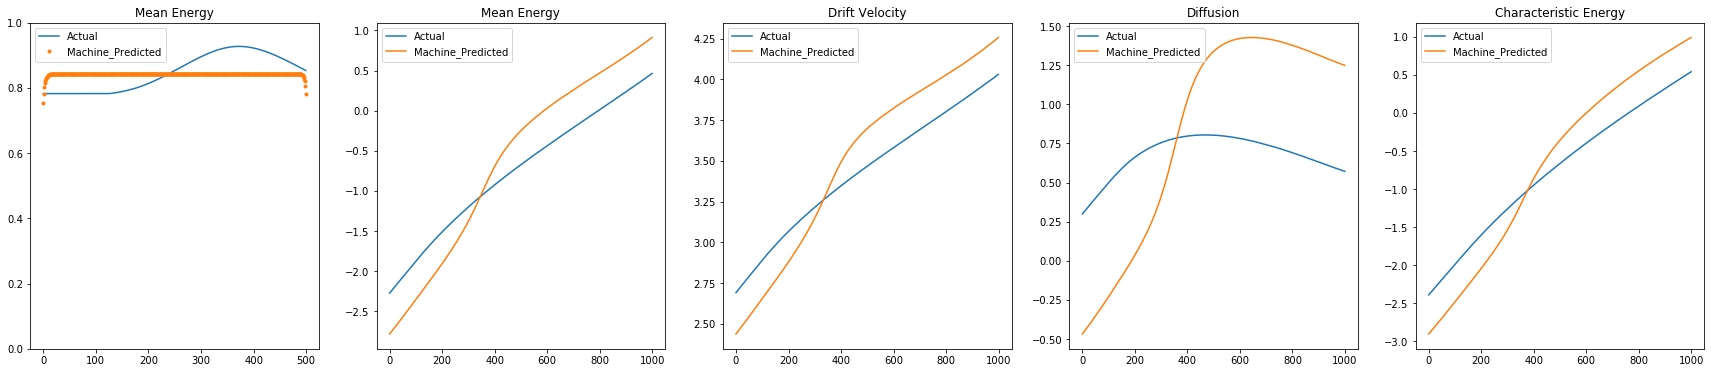

|(1000, 4)


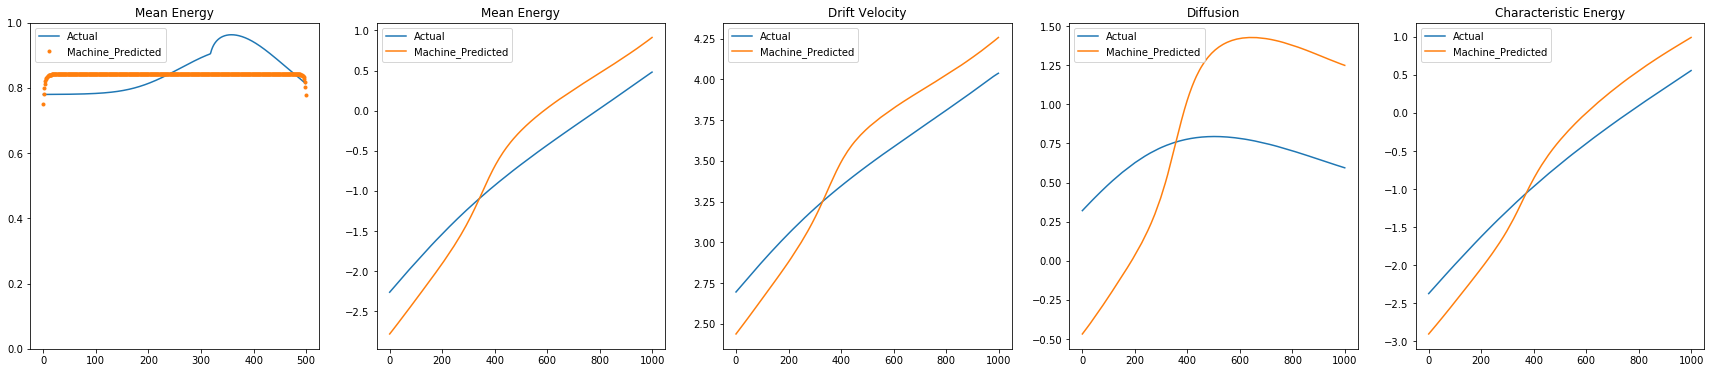

|(1000, 4)


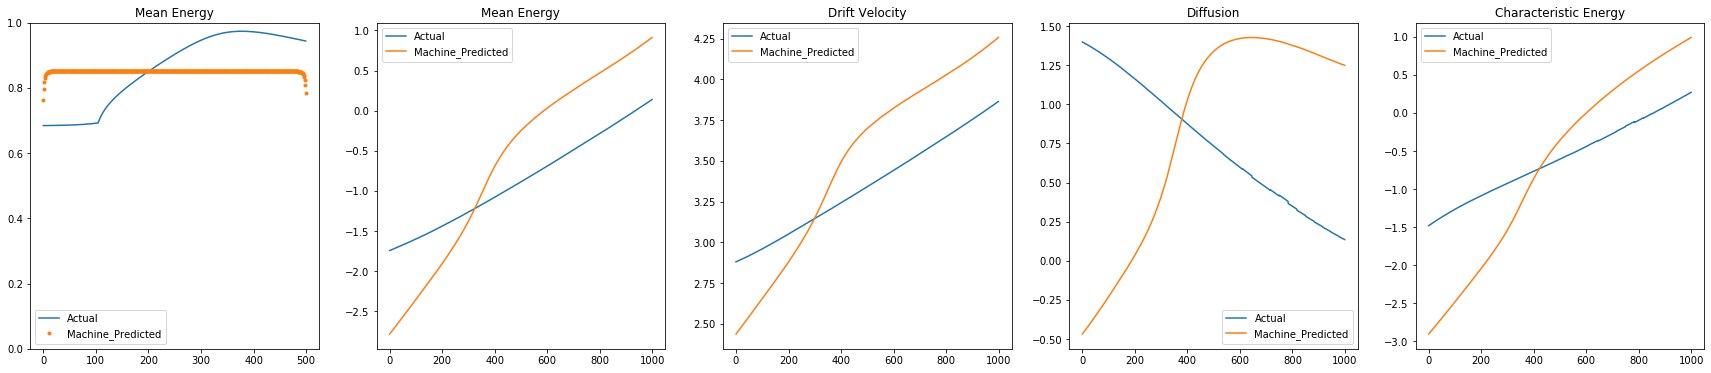

|(1000, 4)


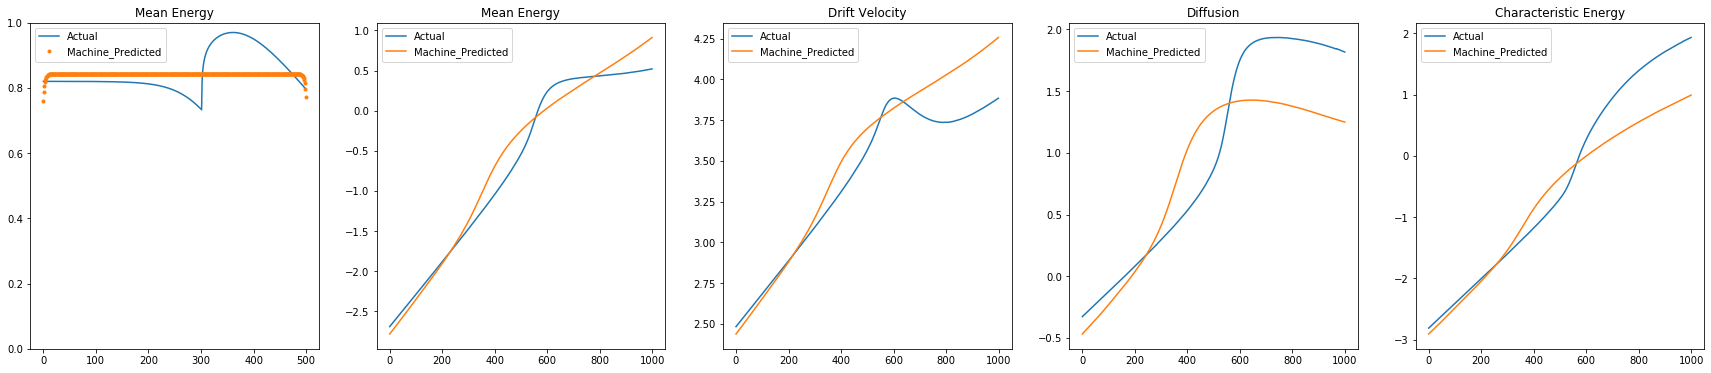

|(1000, 4)


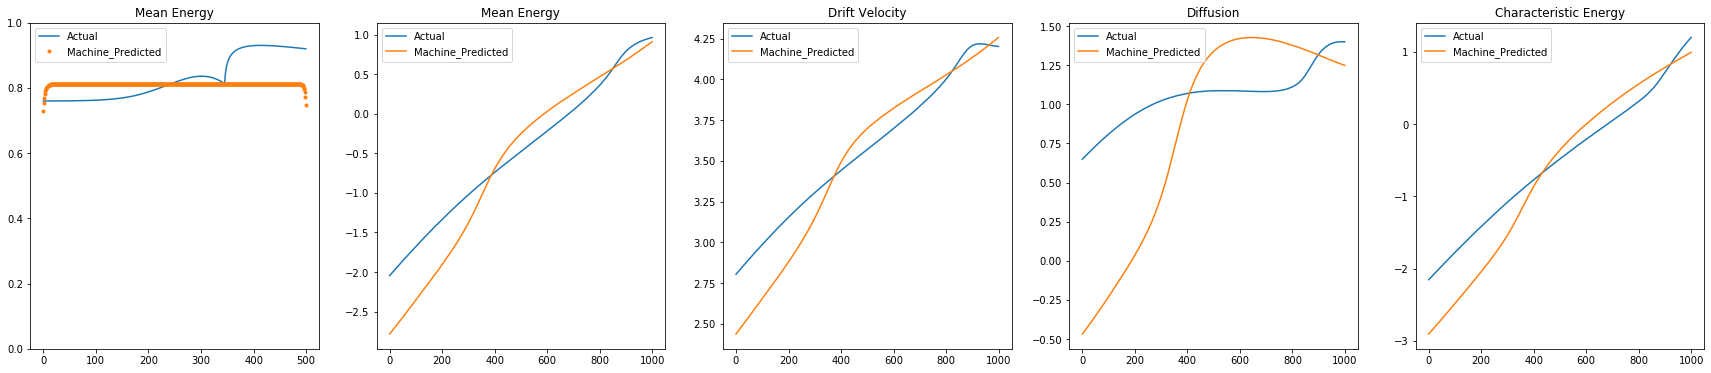

14.344766855239868


In [21]:
#Inverting normalisation of Predicted Y
y_pred=10**((y_hat*y_max)+y_min)*1e-20

E=np.logspace(-3,3,500)

t=time.time()
for i in range(n):
    #plt.loglog(E,y_hat[i,:])
    bolsig.Input(E,y_pred[i,:])
    bolsig.ex(grid=100,n=1000,E_min=1e-3,E_max=10) #n cannot be more than 1000
    #bolsig.Bolsig()
    trans=bolsig.Output(n=1000)
    print('|',end='')
    if np.sum(trans<0)>0:
        plt.loglog(E,Y[i,:,0]*1e20)
        plt.show()
        continue
    print(np.shape(trans))
    trans=np.log10(trans)
    #Denormalisation of X_new to match trans
    for j in range(4):
        X_new[i,:,j]=X_new[i,:,j]*x_std[j]+x_mean[j]
        
    fig, ax = plt.subplots(1, 5, figsize=(30,6))
    title=['Cross Section','Mean Energy',
           'Drift Velocity','Diffusion','Characteristic Energy']
    ax[0].plot(Y[i,:,0])
    ax[0].plot(y_hat[i,:],'.')
    ax[0].legend(['Actual','Machine_Predicted'])
    ax[0].set_title(title[1])
    ax[0].set_ylim((0,1))
    for j in range(4):
        ax[j+1].plot(np.reshape(X_new[i,:],(1000,4))[:,j])
        ax[j+1].plot(trans[:,j])
        ax[j+1].legend(['Actual','Machine_Predicted'])
        ax[j+1].set_title(title[j+1])
    plt.savefig(str(i)+'.png')
    plt.show()
print(time.time()-t)

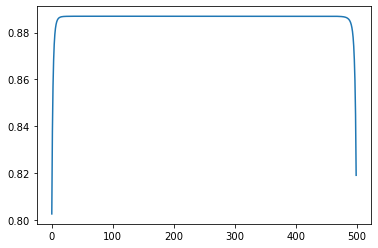

In [24]:
plt.plot(y_hat[0,:,:])